## Blockchain Research: Oracle Attack - MCD Additional Data
### Catherine Gu wcgu@stanford.edu, Stanford University
### May 10, 2020

In [153]:
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
from tqdm import tqdm
from functools import reduce
import scipy.stats as sts
import requests

In [2]:
#Etherscan 
My_API_key = "P6RU4JUJR8PV3DKYR4MSCIPBYXVU8JEW91"

In [3]:
def create_dataframe(response_list):
    """
    Creating a dataframe using the eventLogs responses, extracting input data information
    by doing transactionbyHash call for each of the txs 
    NOTE: this step will take on average 20min to complete all the API calls
    """
    blocks_list = []
    txhash_list = []
    timestamp_list = []
    median_list = []
    
    for response in response_list:
        blocks = [int(response[i]['blockNumber'],16) for i in range(len(response)) if len(response[i]['data']) == 130]
        blocks_list += blocks
        txhash = [response[i]['transactionHash'] for i in range(len(response)) if len(response[i]['data']) == 130]
        txhash_list += txhash
        timestamp = [datetime.fromtimestamp(int(response[i]['timeStamp'],16)) for i in range(len(response)) if len(response[i]['data']) == 130]
        timestamp_list += timestamp
        median = [round(int(response[i]['data'][:66],16)/1e18,3) for i in range(len(response)) if len(response[i]['data']) == 130]
        median_list += median 
    
    df = pd.DataFrame({'blockNumber': blocks_list, 'txhash': txhash_list})
    df = df.set_index('blockNumber')
    df.sort_values(by = ['blockNumber'], ascending = True, inplace = True)

    """
    Caution: takes very long to run this step - request for Transaction by Hash call
    """
    request_call1 = "https://api.etherscan.io/api?module=proxy&action=eth_getTransactionByHash&txhash="
    request_call2 = "&apikey="+My_API_key
    tx_raw = [requests.get(request_call1 + each + request_call2) for each in tqdm(df['txhash'])]
    
    input_data = [raw.json()['result']['input'] for raw in tx_raw]
    df['timestamp'] = timestamp_list
    df['median'] = median_list
    df = df.reset_index()
    df = df.set_index('timestamp')

    for i in range(13):
        val = []
        col_name = "val_" + str(i+1)
        pos = 10 + 64 * (6+i)
        val = [round(int(input_data[each][pos : pos+64],16)/1e18,3) for each in range(len(input_data))]
        df[col_name] = val
    
    return df

# ETH

## Requests to getLogs and getTransactionbyHash

In [4]:
block_call = ["8925057", "9473220", "9709693","10030025"]
ETH_contract = "0x64DE91F5A373Cd4c28de3600cB34C7C6cE410C85"
ETH_response_list = []
for each in block_call:
    ETH_response_ = requests.get("https://api.etherscan.io/api?module=logs&action=getLogs&fromBlock="+each+"&toBlock=latest&address="+ETH_contract+"&topic&apikey="+My_API_key).json()['result']
    ETH_response_list.append(ETH_response_)

In [5]:
df_ETH_all = create_dataframe(ETH_response_list)

100%|██████████| 3064/3064 [19:28<00:00,  2.62it/s] 


In [9]:
df_ETH_all = df_ETH_all.drop_duplicates()
df_ETH_all.shape

(3061, 16)

##### Observe: val_7 == median for all 1204 txs, since it's a sorted array

## External Disagreement

In [157]:
def median_compare(s1,s2, label, ifLog):
    """
    Graph plots the distribution of the difference between the median output from the Maker contract 
    and the benchbark it's compared against
    """
    diff = s1 - s2
    print('mean = {:.2f}, std = {:.2f}, max =  {:.2f}'.format(abs(diff).mean(), abs(diff).std(), abs(diff).max()))
    print()
    print(diff.loc[diff == diff.min()])
    print(diff.loc[diff == diff.max()])
    hist = plt.hist(diff, bins = 30, color = "slategrey")
    if ifLog:
        plt.yscale('log')
    plt.title("Aggregation Differences - {}".format(label))
    plt.savefig("Aggregation Differences - {}".format(label))
    plt.grid()
    plt.show()

#### CryptoCompare CCCAGG

In [11]:
def get_CCCAGG(currency, timestamp_call):
    """
    API call to CryptoCompare to get its CCCAGG data series for the respective currency
    NOTE: timestamp_call needs to be updated from the latest to the last one needed
    - as of currently, set to the latest date is May 10, 2020
    """
    CC_response_list = []
    for each in timestamp_call:
        CC_ = requests.get("https://min-api.cryptocompare.com/data/v2/histohour?fsym="+currency+"&tsym=USD&limit=2000&toTs="+each).json()['Data']
        CC_response_list.append(CC_)
    CC_latest = requests.get("https://min-api.cryptocompare.com/data/v2/histohour?fsym="+currency+"&tsym=USD&limit=2000").json()['Data']
    CC_response_list.append(CC_latest)
    
    CC_list = []
    for CC_response in CC_response_list:
        #Price series is the average of open and close
        CC = [(CC_response['Data'][i]['open'] + CC_response['Data'][i]['close'])/2 for i in range(len(CC_response['Data']))]
        CC_list += CC
    
    timestamp_list = []
    for CC_response in CC_response_list:
        timestamp = [CC_response['Data'][i]['time'] for i in range(len(CC_response['Data']))]
        timestamp_list += timestamp

    ccdf = pd.DataFrame({"time": timestamp_list, "average_price": CC_list})
    ccdf.time = ccdf.time.apply(datetime.fromtimestamp)
    ccdf.sort_values(by = ['time'], ascending = True, inplace = True)

    #remove duplicate entries by column 'time'
    ccdf = ccdf.drop_duplicates(subset = 'time', keep = 'last')
    ccdf = ccdf.set_index('time')
    return ccdf

In [47]:
#Creating CryptoCompare dataframe

timestamp_call = ['1567555200', '1574755200', '1581955200']
ccdf_ETH = get_CCCAGG("ETH", timestamp_call)
ccdf_ETH = ccdf_ETH.reindex(df_ETH_all.index, method = 'ffill')

#### Creating Winsorized Mean for dfs_ff

In [13]:
dfs_ff_winsor_compute = df_ETH_all.loc[:, "val_1" : "val_13"]
winsor = sts.mstats.winsorize(dfs_ff_winsor_compute, limits=[0.05, 0.05], axis = 1)
dfs_ff_winsor = pd.DataFrame(np.ma.filled(winsor), index = dfs_ff_winsor_compute.index)
dfs_ff_winsor['winsor_mean'] = dfs_ff_winsor.mean(axis = 1, skipna = True).round(3)

### Comparing Robust Statistics

mean = 1.26, std = 1.60, max =  18.86

timestamp
2020-03-12 19:15:07   -14.215
dtype: float64
timestamp
2020-03-12 20:32:42    18.86
dtype: float64


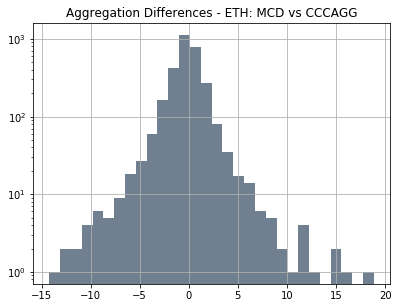

mean = 0.11, std = 0.11, max =  1.06

timestamp
2020-02-09 21:59:40   -1.065
dtype: float64
timestamp
2020-03-13 12:33:15    0.727
dtype: float64


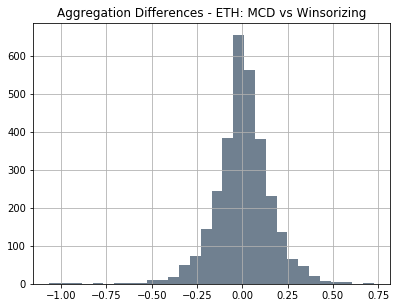

In [158]:
median_compare(df_ETH_all['median'], ccdf_ETH['average_price'], "ETH: MCD vs CCCAGG", True )
median_compare(df_ETH_all['median'], dfs_ff_winsor['winsor_mean'], "ETH: MCD vs Winsorizing", False )

In [143]:
event = "2020-03-12 20:32:42"
(df_ETH_all.loc[event]["median"] - ccdf_ETH.loc[event]['average_price']) / ccdf_ETH.loc[event]['average_price']

0.15294165348903227

In [171]:
df_ETH_all.loc["2020-03-12 19:15:07"]["median"]

94.215

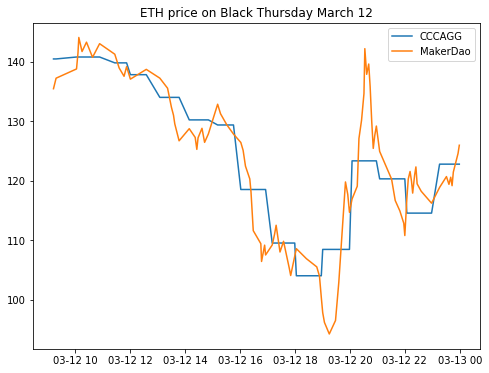

In [172]:
plt.figure(figsize=(8,6))
plt.plot(ccdf_ETH.iloc[1550:1650]["average_price"], label = "CCCAGG")
plt.plot(df_ETH_all.iloc[1550:1650]["median"], label = "MakerDao")
plt.legend()
plt.title("ETH price on Black Thursday March 12")
plt.savefig("Black Thursday March 12: ETH")
plt.show()

## Internal Disagreement

### Boxplot

In [15]:
def get_stats_summary(dfs_dev):
    col = list(dfs_dev)
    mean = [round(np.mean(dfs_dev[c]),3) for c in col]
    sd = [round(np.std(dfs_dev[c]),3) for c in col]
    stats = pd.DataFrame({'Feeders': col, 
                         'mean': mean,
                         'standard deviation': sd})
    stats = stats.set_index('Feeders')
    stats
    return stats

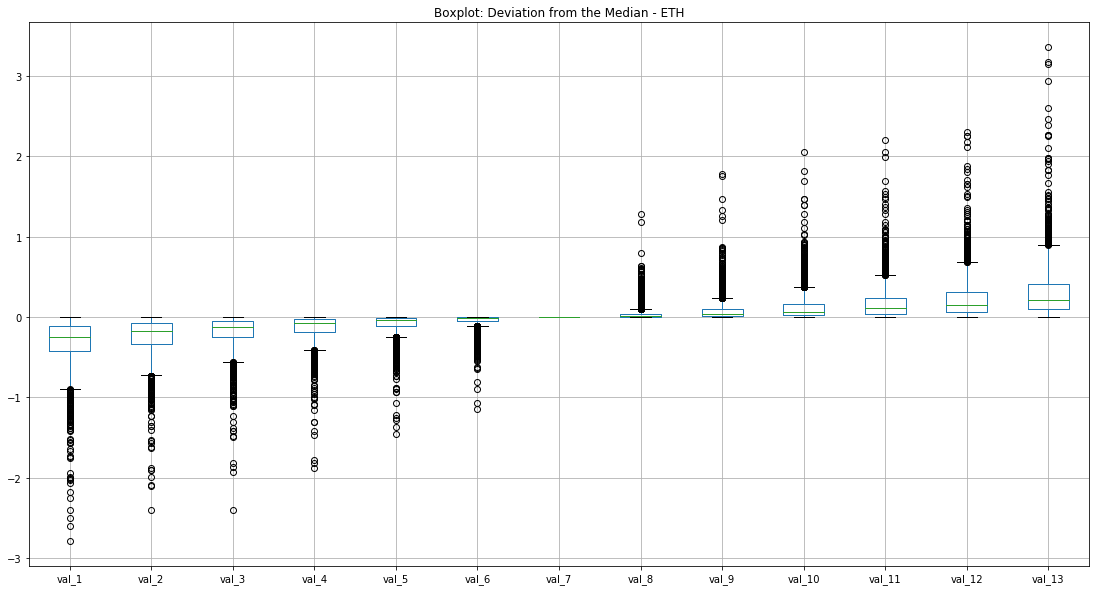

In [169]:
#Creating the deviation from the median dataframe

ETH_dfs_dev = pd.DataFrame(index = df_ETH_all.index)
for i in range(13):
    # *percentage* deviations from the median are calculated as %
    ETH_dfs_dev['val_'+str(i+1)] = (df_ETH_all['val_'+str(i+1)] - df_ETH_all['median'])/df_ETH_all["median"] * 100

plt.figure(figsize=(19,10))
dfs_dev_bp = ETH_dfs_dev.loc[:,"val_1" :  "val_13"]
dfs_dev_bp.boxplot()
plt.title("Boxplot: Deviation from the Median - ETH")
plt.savefig("MCD Boxplot: Deviation from the Median - ETH")
plt.show()  

In [17]:
#Getting the stats table

ETH_stats = get_stats_summary(ETH_dfs_dev)
ETH_stats

,mean,standard deviation
Feeders,,
val_1,-0.305,0.279
val_2,-0.231,0.224
val_3,-0.177,0.190
val_4,-0.131,0.159
val_5,-0.088,0.125
val_6,-0.044,0.081
val_7,0.000,0.000
val_8,0.042,0.083
val_9,0.085,0.130


# BAT

In [18]:
block_call = ["8925076", "9326929", "9659662","9909134"]
BATcontract = "0x18B4633D6E39870f398597f3c1bA8c4A41294966"
BAT_response_list = []
for each in block_call:
    response = requests.get("https://api.etherscan.io/api?module=logs&action=getLogs&fromBlock="+each+"&toBlock=latest&address="+BATcontract+"&topic&apikey="+My_API_key).json()['result']
    BAT_response_list.append(response)

In [19]:
df_BAT = create_dataframe(BAT_response_list)

100%|██████████| 3372/3372 [20:52<00:00,  2.69it/s] 


In [22]:
df_BAT = df_BAT.drop_duplicates()
df_BAT.shape

(3370, 16)

## External Disagreement

#### CryptoCompare CCCAGG

In [144]:
timestamp_call = ['1567555200', '1574755200', '1581955200']
ccdf_BAT = get_CCCAGG("BAT", timestamp_call)
ccdf_BAT = ccdf_BAT.reindex(df_BAT.index, method = 'ffill')

mean = 0.00, std = 0.00, max =  0.02

timestamp
2020-03-12 19:27:44   -0.01875
dtype: float64
timestamp
2020-02-17 23:54:29    0.0206
dtype: float64


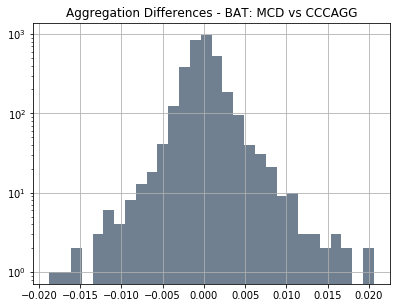

In [160]:
median_compare(df_BAT['median'], ccdf_BAT['average_price'], "BAT: MCD vs CCCAGG", True )

## Internal Disagreement

### Boxplot

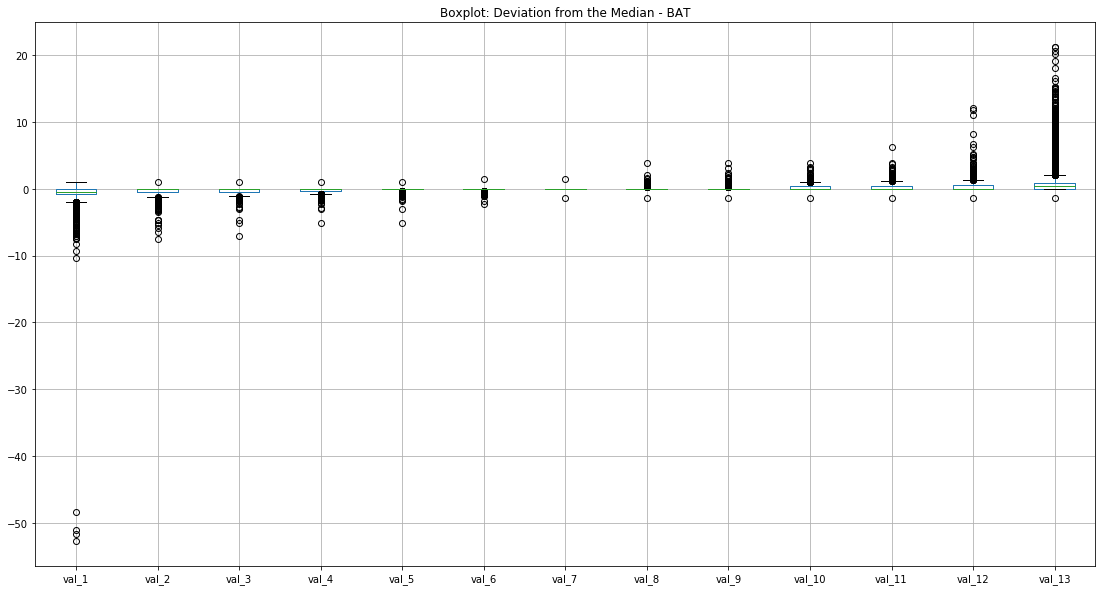

In [162]:
BAT_dfs_dev = pd.DataFrame(index = df_BAT.index)
for i in range(13):
    # *percentage* deviations from the median are calculated as %
    BAT_dfs_dev['val_'+str(i+1)] = (df_BAT['val_'+str(i+1)] - df_BAT['median'])/df_BAT["median"] * 100

plt.figure(figsize=(19,10))
BAT_dfs_dev_bp = BAT_dfs_dev.loc[:,"val_1" :  "val_13"]
BAT_dfs_dev_bp.boxplot()
plt.title("Boxplot: Deviation from the Median - BAT")
plt.savefig("MCD Boxplot: Deviation from the Median - BAT")
plt.show()  

In [26]:
BAT_stats = get_stats_summary(BAT_dfs_dev)
BAT_stats

,mean,standard deviation
Feeders,,
val_1,-0.693,1.956
val_2,-0.297,0.469
val_3,-0.207,0.358
val_4,-0.146,0.294
val_5,-0.098,0.245
val_6,-0.048,0.170
val_7,0.000,0.034
val_8,0.055,0.189
val_9,0.109,0.256
